In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/My Drive/Khoa Luan/"

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [ ]:
import pandas as pd
test = pd.read_csv(path+"NTC_SV/NTC_SV_test.csv")
test = test.dropna()
df = pd.read_csv(path+'NTC_SV/NTC_SV_train.csv')
df = df.dropna()
print(df.head())
print(test.head())

   Unnamed: 0                                             review  label
0           0  đồ_ăn ngon positive hợp_khẩu vị nhiều món nhân...      0
1           1  chè bơ thơm positive có vị ngậy ngậy nhưng lại...      0
2           2  chiều hôm nay mới đi ăn về nghe thiên_hạ đồn q...      0
3           3  mình đặt_hàng qua tin nhắn với cửa_hàng hứa sá...      0
4           4  ghé mấy lần rồi mà không review đi đâu cũng ch...      1
   Unnamed: 0                                             review  label
0           0  gửi xe trong toà nhà somerset thu trước mình đ...      1
1           1  sau khi xem review trên foody mình thấy các bạ...      0
2           2  ít món hải_sản không tươi positive chỉ có món ...      0
3           3  kết gà của popeyes lắm lắm không có chỗ nào ch...      1
4           4  bánh waffles bị negative ngọt quá thêm mứt với...      0


In [ ]:
data = df.review.tolist()
label = df.label.tolist()
data_test = test.review.tolist()
label_test = test.label.tolist()
print(len(data))
print(len(data_test))
data_n = []
for i in data:
  i = i.replace('_','')
  data_n.append(i)
test_v = []
for i in data_test:
  i = i.replace('_','')
  test_v.append(i)

40760
10000


In [ ]:
import pickle
with open(path + 'embeddings_index_vi.pickle', 'rb') as pickle_file:
    embeddings_index = pickle.load(pickle_file)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer  = Tokenizer(num_words = 10000)
tokenizer.fit_on_texts(data_n)

word_index = tokenizer.word_index
print("unique words : {}".format(len(word_index)))
maxlen = 300
sequences =  tokenizer.texts_to_sequences(data_n)
sequences_test =  tokenizer.texts_to_sequences(test_v)
# maxlen = max([len(i.split()) for i in data_n])
# print(maxlen)
data1 = pad_sequences(sequences, maxlen=maxlen)
test1 = pad_sequences(sequences_test, maxlen=maxlen)

# le = LabelEncoder()

# label = le.fit_transform(label)
# labels = label.reshape(-1,1)
# labels_test = le.fit_transform(label_test)
# labels_test = labels_test.reshape(-1,1)
# labels = to_categorical(np.asarray(label))
# labels_test = to_categorical(np.asarray(label_test))
print(data1.shape)
# print('Shape of label tensor:', labels.shape)
x_train,x_val,y_train,y_val = train_test_split(data1,label,test_size=0.15, random_state=48)

unique words : 38212
(40760, 300)


In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))
print(embedding_matrix.shape)
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

(46814, 300)


In [ ]:
from keras.models import Model
from keras.layers import Input, Embedding, SpatialDropout1D, Conv1D, Flatten, Dense, Lambda, LSTM, concatenate
import keras.backend as K

In [ ]:
input_text = Input(shape=(maxlen,))

embedding_layer = Embedding(len(word_index) + 1,
                            300,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=True)(input_text)
text_embed = SpatialDropout1D(0.2)(embedding_layer)

# We shift the document to the right to obtain the left-side contexts
l_embedding = Lambda(lambda x: K.concatenate([K.zeros(shape=(K.shape(x)[0], 1, K.shape(x)[-1])),
                                              x[:, :-1]], axis=1))(text_embed)
# We shift the document to the left to obtain the right-side contexts
r_embedding = Lambda(lambda x: K.concatenate([K.zeros(shape=(K.shape(x)[0], 1, K.shape(x)[-1])),
                                              x[:, 1:]], axis=1))(text_embed)
# use LSTM RNNs instead of vanilla RNNs as described in the paper.
forward = LSTM(256, return_sequences=True)(l_embedding)  # See equation (1)
backward = LSTM(256, return_sequences=True, go_backwards=True)(r_embedding)  # See equation (2)
# Keras returns the output sequences in reverse order.
backward = Lambda(lambda x: K.reverse(x, axes=1))(backward)
together = concatenate([forward, text_embed, backward], axis=2)  # See equation (3).

# use conv1D instead of TimeDistributed and Dense
semantic = Conv1D(256, kernel_size=1, activation="tanh")(together)  # See equation (4).
sentence_embed = Lambda(lambda x: K.max(x, axis=1))(semantic)  # See equation (5).  

dense_layer = Dense(256, activation='relu')(sentence_embed)
output = Dense(1, activation='sigmoid')(dense_layer)

model = Model(input_text, output)


In [ ]:
model.compile(loss='binary_crossentropy', metrics=['acc'], optimizer=Adam(learning_rate=0.001))
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(path+'Test/weights_rcnn_vreview_fastext_sentece.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]
history = model.fit(x_train,y_train,epochs=10,batch_size=128,verbose = 1,validation_data=[x_val,y_val],callbacks=callbacks_list)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 70784 samples, validate on 12492 samples
Epoch 1/10
70784/70784 [==============================] - 441s 6ms/step - loss: 0.3142 - acc: 0.8674 - val_loss: 0.2533 - val_acc: 0.8967

Epoch 00001: val_acc improved from -inf to 0.89673, saving model to /content/drive/My Drive/Khoa Luan/Test/weights_rcnn_vreview_fastext_sentece.h5
Epoch 2/10
70784/70784 [==============================] - 424s 6ms/step - loss: 0.2277 - acc: 0.9108 - val_loss: 0.2391 - val_acc: 0.9050

Epoch 00002: val_acc improved from 0.89673 to 0.90498, saving model to /content/drive/My Drive/Khoa Luan/Test/weights_rcnn_vreview_fastext_sentece.h5
Epoch 3/10
70784/70784 [==============================] - 427s 6ms/step - loss: 0.1815 - acc: 0.9312 - val_loss: 0.2491 - val_acc: 0.9050

Epoch 00003: val_acc did not improve from 0.90498
Epoch 4/10
70784/70784 [==============================] - 438s 6ms/step - loss: 0.1447 - acc: 0.9454 - val_loss: 0.2892 - val_acc: 0.9037

Epoch 00004: val_acc did not improve from 0.904

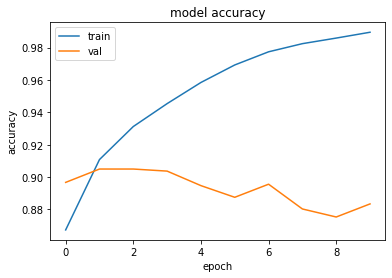

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

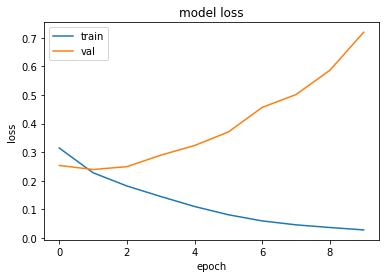

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
def convert_to_sequences(texts):
  sequences =  tokenizer.texts_to_sequences(texts)
  return pad_sequences(sequences, maxlen=maxlen)

In [ ]:
from sklearn import metrics
from keras.models import load_model
model = load_model(path + 'Test/weights_rcnn_NCT_SV_fastext_sentece.h5')
acc = model.predict(convert_to_sequences(test_v))
accr = np.round(acc)
print(metrics.f1_score(label_test, accr))
print(metrics.precision_score(label_test, accr))
print(metrics.recall_score(label_test, accr))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


0.9049309664694279
0.8926070038910506
0.9176
